In [1]:
import numpy as np
import pandas as pd
import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
from xgboost import XGBRegressor

from keras.layers import Embedding, Input, Dense
from keras.models import Model
import keras
import keras.backend as K

import matplotlib.pyplot as plt
import pickle
import joblib

In [2]:
data = {
    'Air_visit': pd.read_csv('gcs://bucket_temp_2021/Restaurant Visitor/air_visit_data.csv'),
    'Air_store': pd.read_csv('gcs://bucket_temp_2021/Restaurant Visitor/air_store_info.csv'),
    'hpg_store': pd.read_csv('gcs://bucket_temp_2021/Restaurant Visitor/hpg_store_info.csv'),
    'air_reserve': pd.read_csv('gcs://bucket_temp_2021/Restaurant Visitor/air_reserve.csv'),
    'hpg_reserve': pd.read_csv('gcs://bucket_temp_2021/Restaurant Visitor/hpg_reserve.csv'),
    'id': pd.read_csv('gcs://bucket_temp_2021/Restaurant Visitor/store_id_relation.csv'),
    'sample_file': pd.read_csv('gcs://bucket_temp_2021/Restaurant Visitor/sample_submission.csv'),
    'date_info': pd.read_csv('gcs://bucket_temp_2021/Restaurant Visitor/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

In [3]:
#merge hr reserve and store id relation
data['hpg_reserve'] = pd.merge(data['hpg_reserve'], data['id'], how='inner', on=['hpg_store_id'])
#new array to merge ar and hr
for reservations in ['air_reserve','hpg_reserve']:
    data[reservations]['visit_datetime'] = pd.to_datetime(data[reservations]['visit_datetime'])#convert to date type
    data[reservations]['visit_dow'] = data[reservations]['visit_datetime'].dt.dayofweek #day of week
    data[reservations]['visit_datetime'] = data[reservations]['visit_datetime'].dt.date #date
    data[reservations]['reserve_datetime'] = pd.to_datetime(data[reservations]['reserve_datetime']) #convert to date type
    data[reservations]['reserve_datetime'] = data[reservations]['reserve_datetime'].dt.date #date
    data[reservations]['reservations_date_diff'] = data[reservations].apply(lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)#diff between two dates
    # Exclude same-week reservations - from aharless kernel
    data[reservations] = data[reservations][data[reservations]['reservations_date_diff'] > data[reservations]['visit_dow']]
      #group diff  datetime ,no of vistors by store id and date (Sum)
    Reservation_Sum = data[reservations].groupby(['air_store_id','visit_datetime'], as_index=False)[['reservations_date_diff', 'reserve_visitors']].sum().rename(columns={'visit_datetime':'visit_date', 'reservations_date_diff': 'rs1', 'reserve_visitors':'rv1'})
     #group diff  datetime ,no of vistors by store id and date (Sum)
    ReservationMean = data[reservations].groupby(['air_store_id','visit_datetime'], as_index=False)[['reservations_date_diff', 'reserve_visitors']].mean().rename(columns={'visit_datetime':'visit_date', 'reservations_date_diff': 'rs2', 'reserve_visitors':'rv2'})
    #merge tmop 1 and temp2 where temp 2  and 1 merge reservations
    data[reservations] = pd.merge(Reservation_Sum, ReservationMean, how='inner', on=['air_store_id','visit_date'])

data['Air_visit']['visit_date'] = pd.to_datetime(data['Air_visit']['visit_date']) #convert to date type
data['Air_visit']['dow'] = data['Air_visit']['visit_date'].dt.dayofweek
data['Air_visit']['year'] = data['Air_visit']['visit_date'].dt.year
data['Air_visit']['month'] = data['Air_visit']['visit_date'].dt.month
data['Air_visit']['visit_date'] = data['Air_visit']['visit_date'].dt.date #date

data['sample_file']['visit_date'] = data['sample_file']['id'].map(lambda x: str(x).split('_')[2])#separate date from id as id and date merge in id
data['sample_file']['air_store_id'] = data['sample_file']['id'].map(lambda x: '_'.join(x.split('_')[:2])) #seperate id
data['sample_file']['visit_date'] = pd.to_datetime(data['sample_file']['visit_date'])
data['sample_file']['dow'] = data['sample_file']['visit_date'].dt.dayofweek
data['sample_file']['year'] = data['sample_file']['visit_date'].dt.year
data['sample_file']['month'] = data['sample_file']['visit_date'].dt.month
data['sample_file']['visit_date'] = data['sample_file']['visit_date'].dt.date


In [4]:
unique_stores = data['sample_file']['air_store_id'].unique()#unique
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)

#sure it can be compressed...
#min visitors 
Visitor_data = data['Air_visit'].groupby(['air_store_id','dow'], as_index=False)['visitors'].min().rename(columns={'visitors':'min_visitors'})
stores = pd.merge(stores, Visitor_data, how='left', on=['air_store_id','dow']) #add column min
#mean visitors
Visitor_data = data['Air_visit'].groupby(['air_store_id','dow'], as_index=False)['visitors'].mean().rename(columns={'visitors':'mean_visitors'})
stores = pd.merge(stores, Visitor_data, how='left', on=['air_store_id','dow'])#add column mean
#median visitos
Visitor_data = data['Air_visit'].groupby(['air_store_id','dow'], as_index=False)['visitors'].median().rename(columns={'visitors':'median_visitors'})
stores = pd.merge(stores, Visitor_data, how='left', on=['air_store_id','dow'])
#max visitors
Visitor_data = data['Air_visit'].groupby(['air_store_id','dow'], as_index=False)['visitors'].max().rename(columns={'visitors':'max_visitors'})
stores = pd.merge(stores, Visitor_data, how='left', on=['air_store_id','dow'])
#count obseervations+
Visitor_data = data['Air_visit'].groupby(['air_store_id','dow'], as_index=False)['visitors'].count().rename(columns={'visitors':'count_observations'})
stores = pd.merge(stores, Visitor_data, how='left', on=['air_store_id','dow']) 
#merge air store file 
stores = pd.merge(stores, data['Air_store'], how='left', on=['air_store_id']) 
# NEW FEATURES FROM Georgii Vyshnia
#seperate genre italian/french to italian french
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))

#separate area hhh--tt ti hht
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
print(stores['air_genre_name'].unique)
lbl = preprocessing.LabelEncoder()#for encoding string as integer
for i in range(10):
  #split the genre and give it a no
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
   
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
#conveerted to nos
print(stores['air_genre_name'].values,stores['air_store_id'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])
#date info file 
data['date_info']['visit_date'] = pd.to_datetime(data['date_info']['visit_date'])
data['date_info']['day_of_week'] = lbl.fit_transform(data['date_info']['day_of_week'])# week no
data['date_info']['visit_date'] = data['date_info']['visit_date'].dt.date

<bound method Series.unique of 0       Italian French
1       Italian French
2              Izakaya
3           Dining bar
4          Cafe Sweets
             ...      
5742             Other
5743    Italian French
5744     Japanese food
5745           Izakaya
5746      Bar Cocktail
Name: air_genre_name, Length: 5747, dtype: object>
[6 6 7 ... 8 7 1] 0       air_00a91d42b08b08d9
1       air_0164b9927d20bcc3
2       air_0241aa3964b7f861
3       air_0328696196e46f18
4       air_034a3d5b40d5b1b1
                ...         
5742    air_fea5dc9594450608
5743    air_fee8dcf4d619598e
5744    air_fef9ccb3ba0da2f7
5745    air_ffcc2d5087e1b476
5746    air_fff68b929994bfbd
Name: air_store_id, Length: 5747, dtype: object


In [5]:
air_visit_visitors = pd.DataFrame(data['Air_visit'].groupby("visit_date")["visitors"].sum()).reset_index()
air_visit_visitors.index +=1

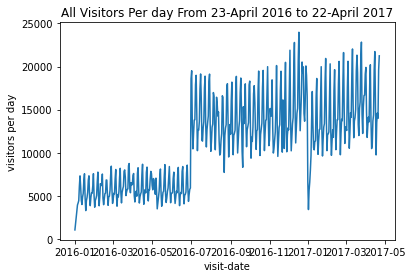

<Figure size 7200x7200 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [6]:
plt.plot(air_visit_visitors["visit_date"],air_visit_visitors["visitors"])

plt.xlabel("visit-date")
plt.ylabel("visitors per day")
plt.title("All Visitors Per day From 23-April 2016 to 22-April 2017")
plt.figure(figsize=(100,100))
plt.figure().subplots_adjust(bottom=0.2)
plt.show()


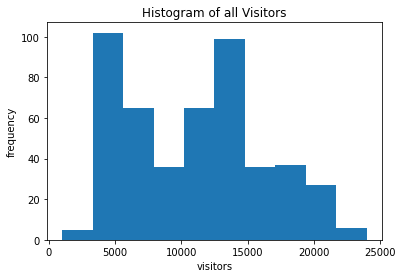

In [7]:
plt.hist(air_visit_visitors["visitors"])
plt.xlabel("visitors")
plt.ylabel("frequency")
plt.title("Histogram of all Visitors")
plt.show()

In [8]:
#merge air_store_data and hol date(date data)
train = pd.merge(data['Air_visit'], data['date_info'], how='left', on=['visit_date']) 
#merge sample submission ad date data
test = pd.merge(data['sample_file'], data['date_info'], how='left', on=['visit_date']) 
#merge train and stores
train = pd.merge(train, stores, how='inner', on=['air_store_id','dow']) 
#merge score
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])
#merge reservations
for reservations in ['air_reserve','hpg_reserve']:
    train = pd.merge(train, data[reservations], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[reservations], how='left', on=['air_store_id','visit_date'])
#create id with date
train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
print(train['total_reserv_sum'])
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']


train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

col = [c for c in train if c not in [ 'id','air_store_id', 'visit_date','visitors']]
print(col)
train = train.fillna(-1)
test = test.fillna(-1)
print("Done")

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
250463   NaN
250464   NaN
250465   NaN
250466   NaN
250467   NaN
Name: total_reserv_sum, Length: 250468, dtype: float64
['dow', 'year', 'month', 'day_of_week', 'holiday_flg', 'min_visitors', 'mean_visitors', 'median_visitors', 'max_visitors', 'count_observations', 'air_genre_name', 'air_area_name', 'latitude', 'longitude', 'air_genre_name0', 'air_area_name0', 'air_genre_name1', 'air_area_name1', 'air_genre_name2', 'air_area_name2', 'air_genre_name3', 'air_area_name3', 'air_genre_name4', 'air_area_name4', 'air_genre_name5', 'air_area_name5', 'air_genre_name6', 'air_area_name6', 'air_genre_name7', 'air_area_name7', 'air_genre_name8', 'air_area_name8', 'air_genre_name9', 'air_area_name9', 'rs1_x', 'rv1_x', 'rs2_x', 'rv2_x', 'rs1_y', 'rv1_y', 'rs2_y', 'rv2_y', 'total_reserv_sum', 'total_reserv_mean', 'total_reserv_dt_diff_mean', 'date_int', 'var_max_lat', 'var_max_long', 'lon_plus_lat', 'air_store_id2']
Done


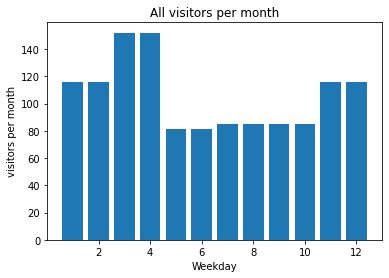

In [9]:

plt.bar(train["month"],train["median_visitors"])
plt.xlabel("Weekday")
plt.ylabel("visitors per month")
plt.title("All visitors per month")
plt.show()

In [10]:
air_visit_visitors["visit_date"]=pd.to_datetime(air_visit_visitors["visit_date"])
air_visit_visitors["month"]=air_visit_visitors["visit_date"].dt.month
c =pd.DataFrame({"Month" : ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
"month" : [1,2,3,4,5,6,7,8,9,10,11,12]})
c.index+=1
air_visit_visitors = air_visit_visitors.merge(c)

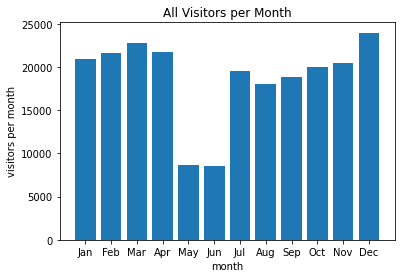

In [11]:

plt.bar(air_visit_visitors["Month"],air_visit_visitors["visitors"])
plt.xlabel("month")
plt.ylabel("visitors per month")
plt.title("All Visitors per Month")
plt.show()

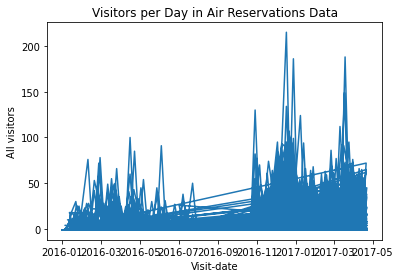

<Figure size 7200x7200 with 0 Axes>

In [12]:
plt.plot(train['visit_date'],train['total_reserv_sum'])
plt.xlabel("Visit-date")
plt.ylabel("All visitors")
plt.title("Visitors per Day in Air Reservations Data")
plt.figure(figsize=(100,100))

plt.show()

In [13]:
train

,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,...,rv2_y,id,total_reserv_sum,total_reserv_mean,total_reserv_dt_diff_mean,date_int,var_max_lat,var_max_long,lon_plus_lat,air_store_id2
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0,7.0,23.843750,...,-1.0,air_ba937bf13d40fb24_2016-01-13,-1.0,-1.0,-1.0,20160113,8.362564,4.521799,175.409667,599
1,air_ba937bf13d40fb24,2016-01-20,31,2,2016,1,6,0,7.0,23.843750,...,-1.0,air_ba937bf13d40fb24_2016-01-20,-1.0,-1.0,-1.0,20160120,8.362564,4.521799,175.409667,599
2,air_ba937bf13d40fb24,2016-01-27,24,2,2016,1,6,0,7.0,23.843750,...,-1.0,air_ba937bf13d40fb24_2016-01-27,-1.0,-1.0,-1.0,20160127,8.362564,4.521799,175.409667,599
3,air_ba937bf13d40fb24,2016-02-03,18,2,2016,2,6,0,7.0,23.843750,...,-1.0,air_ba937bf13d40fb24_2016-02-03,-1.0,-1.0,-1.0,20160203,8.362564,4.521799,175.409667,599
4,air_ba937bf13d40fb24,2016-02-10,32,2,2016,2,6,0,7.0,23.843750,...,-1.0,air_ba937bf13d40fb24_2016-02-10,-1.0,-1.0,-1.0,20160210,8.362564,4.521799,175.409667,599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250463,air_24e8414b9b07decb,2017-04-13,6,3,2017,4,4,0,2.0,5.394737,...,-1.0,air_24e8414b9b07decb_2017-04-13,-1.0,-1.0,-1.0,20170413,8.367414,4.562362,175.364254,96
250464,air_24e8414b9b07decb,2017-04-20,7,3,2017,4,4,0,2.0,5.394737,...,-1.0,air_24e8414b9b07decb_2017-04-20,-1.0,-1.0,-1.0,20170420,8.367414,4.562362,175.364254,96
250465,air_24e8414b9b07decb,2016-07-17,1,6,2016,7,3,0,1.0,3.666667,...,-1.0,air_24e8414b9b07decb_2016-07-17,-1.0,-1.0,-1.0,20160717,8.367414,4.562362,175.364254,96
250466,air_24e8414b9b07decb,2016-12-25,6,6,2016,12,3,0,1.0,3.666667,...,-1.0,air_24e8414b9b07decb_2016-12-25,-1.0,-1.0,-1.0,20161225,8.367414,4.562362,175.364254,96


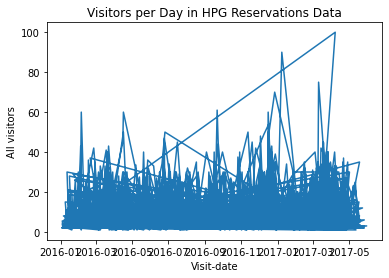

<Figure size 7200x7200 with 0 Axes>

In [14]:

data_2 = data[reservations][["visit_date","rv2"]]

plt.plot(data_2["visit_date"],data_2["rv2"])
plt.xlabel("Visit-date")
plt.ylabel("All visitors")
plt.title("Visitors per Day in HPG Reservations Data")
plt.figure(figsize=(100,100))

plt.show()

In [15]:
data['hpg_reserve']

,air_store_id,visit_date,rs1,rv1,rs2,rv2
0,air_00a91d42b08b08d9,2016-01-15,6,4,6.0,4.0
1,air_00a91d42b08b08d9,2016-01-29,6,5,6.0,5.0
2,air_00a91d42b08b08d9,2016-02-05,16,2,16.0,2.0
3,air_00a91d42b08b08d9,2016-03-08,2,3,2.0,3.0
4,air_00a91d42b08b08d9,2016-04-04,4,1,4.0,1.0
...,...,...,...,...,...,...
10615,air_fea5dc9594450608,2017-04-15,32,4,16.0,2.0
10616,air_fea5dc9594450608,2017-04-18,6,2,6.0,2.0
10617,air_fea5dc9594450608,2017-04-25,9,2,9.0,2.0
10618,air_fea5dc9594450608,2017-04-28,29,3,29.0,3.0


In [16]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

In [17]:
print("Start of Data Load")
numeric_col = ['holiday_flg','min_visitors','mean_visitors','median_visitors','max_visitors','count_observations',
'rs1_x','rv1_x','rs2_x','rv2_x','rs1_y','rv1_y','rs2_y','rv2_y','total_reserv_sum','total_reserv_mean',
'total_reserv_dt_diff_mean','date_int','var_max_lat','var_max_long','lon_plus_lat']

data_col = numeric_col + ['dow', 'year', 'month', 'air_store_id2', 'air_area_name', 'air_genre_name',
'air_area_name0', 'air_area_name1', 'air_area_name2', 'air_area_name3', 'air_area_name4',
'air_area_name5', 'air_area_name6', 'air_genre_name0', 'air_genre_name1',
'air_genre_name2', 'air_genre_name3', 'air_genre_name4']


Start of Data Load


In [18]:
output_list2 = []

output_list2.append(pd.DataFrame({'id': train['air_store_id'], 'visitors': train['air_genre_name']}))
output1 = pd.concat(output_list2)
print(output1)
#from google.colab import files
#output1.to_csv('output1.csv', index=False)
#files.download('output1.csv')
#print("Your submission was successfully saved!")

                          id  visitors
0       air_ba937bf13d40fb24         4
1       air_ba937bf13d40fb24         4
2       air_ba937bf13d40fb24         4
3       air_ba937bf13d40fb24         4
4       air_ba937bf13d40fb24         4
...                      ...       ...
250463  air_24e8414b9b07decb        11
250464  air_24e8414b9b07decb        11
250465  air_24e8414b9b07decb        11
250466  air_24e8414b9b07decb        11
250467  air_24e8414b9b07decb        11

[250468 rows x 2 columns]


In [19]:
X = train.copy()
print(X)

                air_store_id  visit_date  visitors  dow  year  month  \
0       air_ba937bf13d40fb24  2016-01-13        25    2  2016      1   
1       air_ba937bf13d40fb24  2016-01-20        31    2  2016      1   
2       air_ba937bf13d40fb24  2016-01-27        24    2  2016      1   
3       air_ba937bf13d40fb24  2016-02-03        18    2  2016      2   
4       air_ba937bf13d40fb24  2016-02-10        32    2  2016      2   
...                      ...         ...       ...  ...   ...    ...   
250463  air_24e8414b9b07decb  2017-04-13         6    3  2017      4   
250464  air_24e8414b9b07decb  2017-04-20         7    3  2017      4   
250465  air_24e8414b9b07decb  2016-07-17         1    6  2016      7   
250466  air_24e8414b9b07decb  2016-12-25         6    6  2016     12   
250467  air_24e8414b9b07decb  2017-01-08         4    6  2017      1   

        day_of_week  holiday_flg  min_visitors  mean_visitors  ...  rv2_y  \
0                 6            0           7.0      23.843

In [20]:
air_store_genreWise1 = pd.DataFrame(data['Air_store'].groupby("air_genre_name")["air_store_id"].count()).reset_index()
air_store_genreWise1.index+=1
air_store_genreWise1 = air_store_genreWise1.rename(columns={"air_store_id":"noOfstore"})
air_store_genreWise1= air_store_genreWise1.sort_values(by="noOfstore",ascending=False)

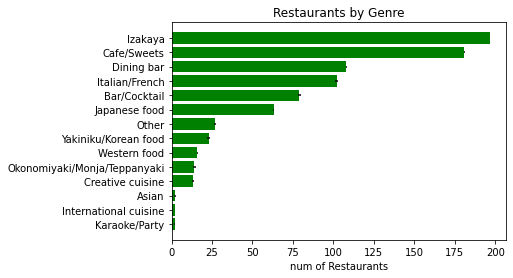

In [21]:
fig, agen = plt.subplots()
error = np.random.rand(len(air_store_genreWise1["air_genre_name"]))
y_pos = np.arange(len(air_store_genreWise1["air_genre_name"]))
agen.barh(y_pos, air_store_genreWise1["noOfstore"], xerr=error, align='center',
        color='green', ecolor='black')
agen.set_yticks(y_pos)
agen.set_yticklabels(air_store_genreWise1["air_genre_name"])
agen.invert_yaxis()  # labels read top-to-bottom
agen.set_xlabel('num of Restaurants')
agen.set_title('Restaurants by Genre')

plt.show()

In [22]:
X_test = test[data_col].copy()
print(X_test)

       holiday_flg  min_visitors  mean_visitors  median_visitors  \
0                0           2.0       2.000000              2.0   
1                0           1.0      22.457143             19.0   
2                0           1.0      24.350000             24.5   
3                0          15.0      28.125000             28.0   
4                0          15.0      29.868421             30.0   
...            ...           ...            ...              ...   
32014            0           2.0       7.439024              7.0   
32015            0           1.0       4.000000              3.5   
32016            0           1.0       4.200000              4.0   
32017            0           1.0       4.526316              4.0   
32018            0           1.0       4.634146              4.0   

       max_visitors  count_observations  rs1_x  rv1_x  rs2_x  rv2_x  ...  \
0               2.0                 1.0   -1.0   -1.0   -1.0   -1.0  ...   
1              47.0            

In [23]:

train['air_genre_name'].values

array([ 4,  4,  4, ..., 11, 11, 11])

In [24]:
X_train = list(X[data_col].T.values)


In [25]:
Y_train = np.log1p(X['visitors']).values
nn_train = [X_train, Y_train]
nn_test = [list(X_test[data_col].T.values)]
print("Train and test data prepared") 

Train and test data prepared


In [26]:
#***************************************Random Forest
#XGBOOST_REGRESSOR_PARAMS = dict(
    #learning_rate=0.2, n_estimators=13, subsample=0.8, colsample_bytree=0.8, 
   # max_depth=10, n_jobs=-1
#)
model2 = ensemble.RandomForestRegressor(n_estimators=13, random_state=3, max_depth=18,
                                        min_weight_fraction_leaf=0.0002)

In [27]:
# *********************** Training and Validation Data *************************#
train_X = train[col]
train_X = train_X[train_X['year'] == 2016]
train_y = train[train['year'] == 2016]
test_X =  train[col]
test_X = test_X[test_X['year'] == 2017]
test_y = train[train['year'] == 2017]
# *********************** Training and Validation Data *************************#
#**********************************************************
print(train_y['visitors'].values)
model2.fit(train_X, np.log1p(train_y['visitors'].values))
print("Model2 trained")
preds2 = model2.predict(test_X)
print('RMSE RandomForestRegressor: ', RMSLE(np.log1p(test_y['visitors'].values), preds2))

[25 31 24 ...  2  1  6]
Model2 trained
RMSE RandomForestRegressor:  0.5484037352841548


In [28]:
#from google.colab import files
#train_X.to_csv('my_submission.csv', index=False)
#files.download('my_submission.csv')
#print("Your submission was successfully saved!")

In [29]:
output_trainx=(pd.DataFrame({'id': train_X['air_store_id2'], 'visitors': train_X['mean_visitors'],'genre': train_X['air_genre_name'],'year': train_X['year']}))
output_trainy=(pd.DataFrame({'id': train_y['air_store_id'], 'visitors': train_y['visitors'],'genre': train_y['air_genre_name'],'year': train_y['year']}))
output_testx=(pd.DataFrame({'id': test_X['air_store_id2'], 'visitors': test_X['mean_visitors'],'genre': test_X['air_genre_name'],'year': test_X['year']}))
output_testy=(pd.DataFrame({'id': test_y['air_store_id'], 'visitors': test_y['visitors'],'genre': test_y['air_genre_name'],'year': test_y['year']}))

In [30]:
model2.fit(output_trainx, np.log1p(output_trainy['visitors'].values))
print("Model2 trained")
preds2 = model2.predict(output_testx)
print(preds2)
print('RMSE RandomForestRegressor: ', RMSLE(np.log1p(output_testy['visitors'].values), preds2))

Model2 trained
[3.20511701 3.20511701 3.20511701 ... 1.71771996 1.71771996 1.36180756]
RMSE RandomForestRegressor:  0.5333327717446809


In [31]:
Pkl_Filename = "model_tree.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model2, file)

In [32]:
#XGB MODel
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [33]:
xgbr = xgb.XGBRegressor(verbosity=0) 
print(xgbr)
xgbr1 = xgb.XGBRegressor(verbosity=0) 



XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=0)


In [34]:
xgbr.fit(train_X, np.log1p(train_y['visitors'].values))
xgbr1.fit(output_trainx, np.log1p(output_trainy['visitors'].values))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0)

In [35]:
score = xgbr.score(train_X, np.log1p(train_y['visitors'].values)  )
print("Training score: ", score)

Training score:  0.6544234531871935


In [36]:
ypred = xgbr.predict(test_X)
fastapixgbr=xgbr1.predict(output_testx)
mse = mean_squared_error(np.log1p(test_y['visitors'].values), ypred)
print("MSE: %.2f" % mse)
MSE: 3.35
print("RMSE: %.2f" % (mse**(1/2.0)))
RMSE: 1.83

print('RMSE XGB: ', RMSLE(np.log1p(test_y['visitors'].values), ypred))

MSE: 0.43
RMSE: 0.66
RMSE XGB:  0.6590761152837324


In [37]:
Pkl_Filename1 = "model_xgbr.pkl"  

with open(Pkl_Filename1, 'wb') as file:  
    pickle.dump(xgbr1, file)

In [38]:
output_list = []

output_list.append(pd.DataFrame({'id': test_y['air_store_id'], 'visitors': test_y['visitors']}))

In [39]:
output = pd.concat(output_list).sort_index()
print(output)

                          id  visitors
49      air_ba937bf13d40fb24        12
50      air_ba937bf13d40fb24        24
51      air_ba937bf13d40fb24        25
52      air_ba937bf13d40fb24        10
53      air_ba937bf13d40fb24        22
...                      ...       ...
250461  air_24e8414b9b07decb         7
250462  air_24e8414b9b07decb         8
250463  air_24e8414b9b07decb         6
250464  air_24e8414b9b07decb         7
250467  air_24e8414b9b07decb         4

[77286 rows x 2 columns]


**Quantization**

In [40]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
train = train.sort_values('visit_date')
values = np.log1p(train['visitors'].values).reshape(-1,1)
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [41]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size

V_train, V_test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(V_train), len(V_test))

175327 75141


In [42]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [43]:
look_back = 1
trainX, trainY = create_dataset(V_train, look_back)
testX, testY = create_dataset(V_test, look_back)

175326
75140


In [44]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class LSTMModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, ntoken, ninp, nhid, nlayers, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.LSTM(ninp, nhid, nlayers, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

        self.init_weights()

        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output)
        return decoded, hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                weight.new_zeros(self.nlayers, bsz, self.nhid))

In [46]:


model = LSTMModel(
  len(trainX),
    ninp = 512,
    nhid = 256,
    nlayers = 5,
)
model.eval()
print(model)

LSTMModel(
  (drop): Dropout(p=0.5, inplace=False)
  (encoder): Embedding(175326, 512)
  (rnn): LSTM(512, 256, num_layers=5, dropout=0.5)
  (decoder): Linear(in_features=256, out_features=175326, bias=True)
)


In [47]:
import torch.quantization

quantized_model = torch.quantization.quantize_dynamic(
    model, {nn.LSTM, nn.Linear}, dtype=torch.qint8
)
print(quantized_model)

LSTMModel(
  (drop): Dropout(p=0.5, inplace=False)
  (encoder): Embedding(175326, 512)
  (rnn): DynamicQuantizedLSTM(512, 256, num_layers=5, dropout=0.5)
  (decoder): DynamicQuantizedLinear(in_features=256, out_features=175326, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)


In [48]:
import os
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(model)
print_size_of_model(quantized_model)

Size (MB): 550.885415
Size (MB): 407.586743


**Error Analysis**


In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_test_encodederror= le.fit_transform(np.log1p(test_y['visitors'].values))
y_pred_encodederror = le.fit_transform(preds2)

print("Mean squared error: ", mean_squared_error(y_test_encodederror, y_pred_encodederror))
print("Mean Absolute error: ", mean_absolute_error(y_test_encodederror, y_pred_encodederror))


Mean squared error:  10732386.105504232
Mean Absolute error:  2879.9439484512072
